In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as la
from scipy . interpolate import UnivariateSpline
import scipy.integrate as integ
from scipy.optimize import root

# Elementos finitos en una dimensión

Vamos a estudiar la técnica de los elementos finitos, comenzando por problemas de contorno en una dimensión espacial para entender bien la técnica.

## Problemas de contorno

Estudiamos problemas de contorno para ecuaciones diferenciales ordinarias. La variable respecto de la que derivamos _típicamente_ no representa el tiempo, sino que modelizamos problemas estacionarios en una dimensión espacial.
Aunque se pueden definir problemas de contorno de interés con la variable temporal

Comenzamos con una sóla ecuación diferencial:
$$
y'' = f(x,y,y')
$$
Definida en un intervalo $[a,b]$, prescribiendo los valores de $f$ en los extremos del intervalo:

$$
y'' = f(x,y,y'),\; a\leq x\leq b, y(a)=\alpha, y(b)=\beta
$$

Comparamos nuestro __problema de contorno (PC)__:

$$
y'' = f(x,y,y'),\; a\leq x\leq b, y(a)=\alpha, y(b)=\beta
$$

con el __problema de valor de inicial (PVI)__ para la misma ecuación diferencial, que necesita que especifiquemos el valor inicial $y(a)$ y la velocidad inicial $y'(a)$:

$$
y'' = f(x,y,y'),\; a\leq x\leq b, y(a)=\alpha, y'(a)=t
$$

La __teoría__ de los problemas de contorno es distinta a la de los de los problemas de valor inicial: problemas muy regulares pueden tener más de una solución, o no tener ninguna. _La solución única está garantizada_ cuando $f$ es derivable y además:
 - $\frac{\partial f}{\partial y} > 0$
 - $|\frac{\partial f}{\partial y'}| < M$
 

## Ejemplo

Representamos el desplazamiento vertical de una viga horizontal mediante una función $w(x)$ que indica el desplazamiento vertical en la posición $x$ medida desde el extremo izquierdo de la viga.

![viga](viga.png)

La siguiente ecuación modeliza el desplazamiento vertical $w$ de una viga con carga homogénea y sujeta en los dos extremos:

$$
w''(x) = \frac{S}{EI}w(x) + \frac{q}{2EI}x(x-l)\; 0<x<l
$$

donde
 - $l$: longitud de la viga
 - $E$: módulo elástico de la viga
 - $I$: momento de inercia de la sección de la viga
 - $S$: tensión horizontal en los extremos de la viga
 - $q$: carga de la viga por unidad de longitud

Fijamos los valores $l=120, E=3\cdot 10^{7}, S=1000, I=625$ (en unidades compatibles que no especificamos).

## `integ.solve_bvp` 

Resolvemos el problema con `integ.solve_bvp`, método de la librería `scipy` para resolver problemas de contorno _en una dimensión espacial_. La sintaxis no es tan intuitiva como la de `integ.solve_ivp` (`:-/`)
```python
integ.solve_bvp(
    fun, # función que define la ecuación diferencial
    bc,  # función que define las condiciones de frontera, que pueden ser bastante generales
    xs,  # un array con valores para la variable independiente x
    ys   # un "primer intento" (initial guess) para los valores de y en los puntos de xs
)
```

In [2]:
l = 120
Q = 100
E = 3e7
S = 1e3
I = 625

def fun(x,ys):
    'Define la EDO'
    y, yp = ys
    return [yp, ((S/(E*I))*y  + (Q*x/(2*E*I))*(x-l))]

# Las condiciones en los extremos
a, b = 0, l
alpha, beta = 0, 0
def bc(ya, yb):
    return np.array([ya[0] - alpha, yb[0] - beta])

In [3]:
N = 5
xs = np.linspace(0, l, N)
ys = np.zeros((2, N))
sol = integ.solve_bvp(fun, bc, xs, ys)
plt.title(sol['message'])
plt.xlabel('x')
plt.ylabel('beam displacement')
plt.plot(sol['x'], -sol['y'][0,:])

In [4]:
# Repetimos para N=50
N = 50
xs = np.linspace(0, l, N)
ys = np.zeros((2, N))
sol = integ.solve_bvp(fun, bc, xs, ys)
plt.title(sol['message'])
plt.xlabel('x')
plt.ylabel('beam displacement')
plt.plot(sol['x'], -sol['y'][0,:])

## Elementos finitos

Al contrario que `solve_bvp`, sólo vamos a estudiar la técnica de los elementos finitos para _problemas lineales_ con una forma concreta (pero que aparece en muchos dominios distintos).

Queremos resolver una ecuación del tipo:

$$
-u'' + Vu = f 
$$

o, escribiendo la variable $x$

$$
-u''(x) + V(x)u(x) = f(x)
$$

en un intervalo $[a,b]$, con condiciones de frontera $u(a)=u(b)=0$.

Fijamos una serie de nodos $x_0=a,x_1,\dots,x_{n}=b$.
Buscamos una solución aproximada en el espacio $V$ de funciones lineales en cada intervalo $[x_i,x_{i+1}]$, que además valen 0 en los extremos: $u(x_0)=u(x_n)=0$.

En este espacio, la ecuación anterior es cierta si y sólo si el producto de $-u''(x) + V(x)u(x) - f(x)$ por cualquier función $v\in V$ tiene integral 0:

$$
\int_a^b \left(-u''(x) + V(x)u(x) - f(x) \right) v(x) \: d x= 0\;\text{ para cualquier }v\in V
$$


Esa integral se puede simplificar un poco integrando por partes (usando que $v(x_0)=v(x_n)=0$).

$$
\int_a^b u'(x)v'(x) + V(x)u(x)v(x) - f(x) v(x) = 0\;\text{ para cualquier }v\in V
$$

y vemos que esta integral es exactamente la derivada del funcional $E$ en el "punto" $u$ y en la dirección $v$, donde $E$ es un _funcional de energía_ definido en el espacio $V$ (a cada función de $V$ le asigna un número real):

$$
E(u)=\int_a^b \frac{1}{2}u'(x)^2 + \frac{1}{2}V(x)u(x)^2 - f(x) u(x) = 0.
$$

> _Cualquier solución de la ecuación diferencial es un punto crítico del funcional de energía, y viceversa._

$$
-u'' + Vu = f\; \text{ en sentido "débil", en }V\Leftrightarrow \nabla_u E(v)=0 \text{ para cualquier }v\in V\Leftrightarrow \nabla_u E=0
$$

De hecho, el funcional $E$ es cuadrático y convexo, y tiene un único punto crítico, que es un mínimo.

Cualquier función de $V$ se puede escribir en la forma
$$
u(x) = \sum_{i=1}^n c_i\phi_i(x)
$$
Donde $\phi_i$ son funciones que forman una base de $V$. 
La función $\phi_i$ es la única función de $V$ que vale $1$ en $x_i$, y $0$ en todos los demás nodos

![finite_element_d1.png](finite_element_d1.png)
![finite_element_d1_bis.png](finite_element_d1_bis.png)


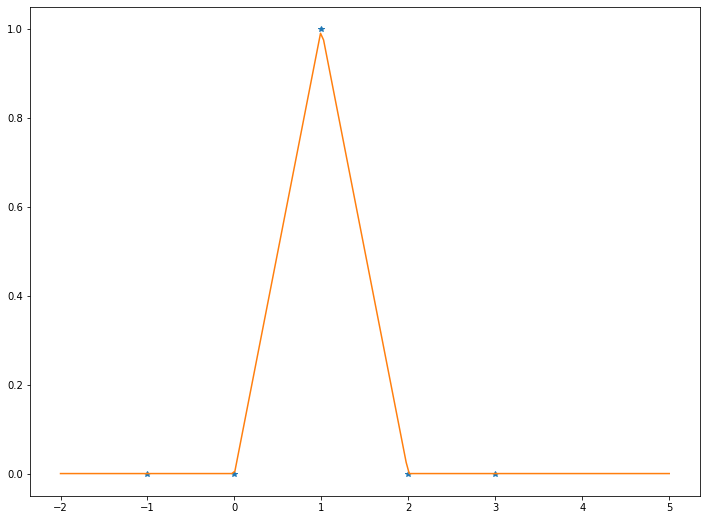

In [5]:
xdata = [-1,0,1,2,3]
ydata = [0,0,1,0,0]

from scipy . interpolate import UnivariateSpline
s = UnivariateSpline(xdata, ydata, k=1, s=0)

x_eval = np.linspace(-2, 5, 200)
y_linear_spline = s(x_eval)

plt.figure(figsize=(12,9))
plt.plot(xdata, ydata, '*', label='nodos de interpolación')
plt.plot(x_eval, y_linear_spline, label='spline lineal')

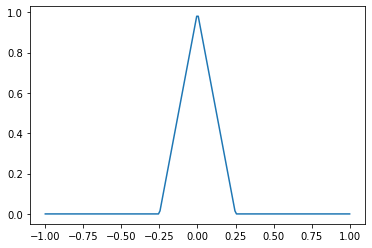

In [6]:
def FE(x1, x2, x3):
    '''Una llamada a FE nos devuelve una función lineal a trozos f
    que vale:
        - f(x1) = f(x3) = 0
        - f(x2) = 1
        - lineal en (x1, x2) y (x2, x3)
        - 0 fuera del intervalo (x1, x3)
    '''
    xdata = [x1-1, x1, x2, x3, x3+1]
    ydata = [0,0,1,0,0]
    # Interpolación lineal a trozos de xdata e ydata
    # continuada por cero entre -oo y x1, y también entre x3 y +oo
    return UnivariateSpline(xdata, ydata, k=1, s=0)

phi = FE(-0.25, 0, 0.25)
x_eval = np.linspace(-1,1,200)
y_eval = phi(x_eval)
plt.plot(x_eval, y_eval)

Si desarrollamos el funcional de energía en esta base tenemos:
$$
\begin{array}{rcll}
E(u)&=&\int_a^b &(u'(x))^2 + V(x)u(x)^2 - f(x) u(x) = 0\\
E\left(\sum_{i=1}^n c_i\phi_i(x)\right)&=&\Large\int_a^b& \left(\sum_{i=1}^n c_i\phi_i'(x)\sum_{j=1}^n c_j\phi_j'(x)\right) \\
                        &&&+ V(x)\left(\sum_{i=1}^n c_i\phi_i(x)\sum_{j=1}^n c_j\phi_j(x)\right)\\
                        &&&- f(x)\left(\sum_{i=1}^n c_i\phi_i(x)\right)  = 0
\end{array}
$$
$$
\begin{array}{rcl}
E\left(\sum_{i=1}^n c_i\phi_i(x)\right)&=& \left(\sum_{i=1}^n \sum_{j=1}^n c_jc_i\int_a^b\phi_i'(x)\phi_j'(x)\right) \\
                        &&+\left(\sum_{i=1}^n \sum_{j=1}^n c_jc_i\int_a^b V(x)\phi_i(x)\phi_j(x)\right)\\
                        &&- \sum_{i=1}^n c_i\int_a^b f(x)\phi_i(x)  = 0
\end{array}
$$

Definimos:
 - Una matriz $A_1$ cuya entrada $i,j$ es $\int_a^b\phi_i'(x)\phi_j'(x)\:dx$
 - Una matriz $A_2$ cuya entrada $i,j$ es $\int_a^b V(x)\phi_i(x)\phi_j(x)\:dx$
 - La matriz $A$ es $A=A_1+A_2$.
 - Un vector $\mathbf{b}$ cuya entrada $i$ es $\int_a^b f(x)\phi_i(x)\:dx$
 - Un vector $\mathbf{c}$ cuya entrada $i$ es la incógnita $c_i$.
y el funcional $E$ toma la forma:
$$
\begin{array}{rcll}
E(u)=E\left(\sum_{i=1}^n c_i\phi_i(x)\right)=E(\mathbf{c})&=&\mathbf{c}^T\cdot A\cdot \mathbf{c} - \mathbf{c}^T\cdot\mathbf{b}\\
\end{array}
$$

Es importante observar que las integrales que definen $A$ se anulan si j no es i, i-1 ó i+1, porque $\phi_{i}(x)$ se anula si $x$ no está en $[x_{i-1}, x_{i+1}]$, y $\phi_{j}(x)$ se anula si $x$ no está en $[x_{j-1}, x_{j+1}]$, luego el producto $\phi_{i}(x)\phi_{j}(x)$ se anula si $x$ no está en la intersección de esos dos intervalos.

Es decir, __la matriz $A$ es tridiagonal__, con $-2$ en la diagonal principal, y $1$ en las dos diagonales adyacentes.

El funcional $E$ es cuadrático y definido positivo, y por tanto tiene un mínimo absoluto en su único punto crítico, que se obtiene derivando:
$$
\nabla_{\mathbf{c}} E = A\cdot \mathbf{c} - \mathbf{b} = \mathbf{0}
$$
y finalmente encontramos una solución de nuestro problema variacional resolviendo un sistema de ecuaciones lineales.

In [15]:
l = 120
Q = 100
E = 3e7
S = 1e3
I = 625

#Esta línea define x0, xf (números) y x_span (una lista con esos dos mismos números)
x0, xf = x_span = [0, l]
alpha, beta = 0, 0

# y''(x) = p(x) y'(x) + q(x) y(x) + r(x)

def V(x):
    #Devuelve un array del mismo tamaño que el array xs, toma el valor
    #constante S/(E*I)
    return (S/(E*I))*np.ones_like(x)

def f(x):
    return (Q/(2*E*I))*x*(x-l)

# Probamos distintos valores
n = 120

# Mallado
h = (xf - x0)/n
xs = np.linspace(x0,xf,n+1)
#puntos interiores
xs_int = xs[1:-1]

# Matriz banda A
A = np.zeros((n-1,n-1))
# Vector b
b = np.zeros(n-1)
for i in range(n-1):
    xi = xs_int[i]
    xi_menos = xi - h
    xi_mas   = xi + h
    phi_i = FE(xi_menos, xi, xi_mas)
    A[i,i] = (
        (2/h) + integ.quad(lambda x: V(x)*phi_i(x)**2, xi_menos,xi_mas)[0]
    )
    b[i] = -integ.quad(lambda x: f(x)*phi_i(x), xi_menos,xi_mas)[0]
    if i>0:
        phi_i_menos = FE(xi-2*h, xi-h, xi)
        A[i,i-1] = (
        (-1/h) + integ.quad(lambda x: V(x)*phi_i(x)*phi_i_menos(x), xi_menos,xi)[0]
        )
    if i<n-2:
        phi_i_mas = FE(xi, xi+h, xi+2*h)
        A[i,i+1] = (
        (-1/h) + integ.quad(lambda x: V(x)*phi_i(x)*phi_i_mas(x), xi,xi_mas)[0]
        )

# Solucion
y_int = la.solve(A, b)
ys_FEM = np.zeros(n+1)
# ys_FEM vale 0 en los extremos del intervalo
ys_FEM[1:-1] = y_int

In [8]:
A.round(3)

array([[ 2., -1.,  0., ...,  0.,  0.,  0.],
       [-1.,  2., -1., ...,  0.,  0.,  0.],
       [ 0., -1.,  2., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ...,  2., -1.,  0.],
       [ 0.,  0.,  0., ..., -1.,  2., -1.],
       [ 0.,  0.,  0., ...,  0., -1.,  2.]])

Recordemos que nuestra aproximación a la solución es
$$
u(x)=\sum_{i=1}^n c_i\phi_i(x)
$$
pero como $u$ es lineal a trozos, podemos hacer la gráfica de u usando el comando `plot`, que interpola linealmente.
Los valores de $u$ en los nodos son exactamente:
$$
u(x_j)=\sum_{i=1}^n c_i\phi_i(x_j) = c_j
$$
porque $\phi_i(x_j)$ vale 0 cuando $i\neq j$ y 1 cuando $i=j$.

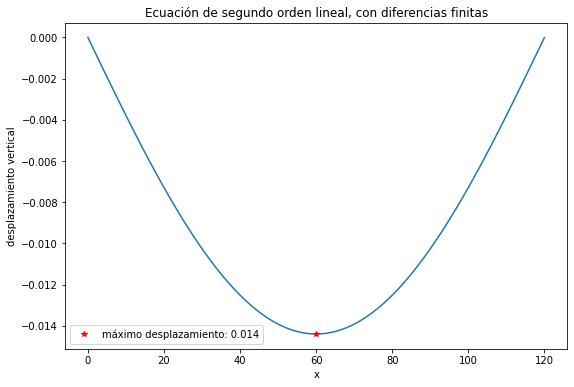

In [9]:
#Ponemos signo negativo al desplazamiento, ya que es más intuitivo 
#graficar el desplazamiento hacia abajo
plt.figure(figsize=(9,6))
plt.plot(xs,-ys_FEM)
plt.xlabel('x')
plt.ylabel('desplazamiento vertical')
plt.title('Ecuación de segundo orden lineal, con diferencias finitas')
#Se ve a ojo que el máximo se alcanza en el punto medio
#También se puede deducir de la simetría del problema
#Pero este código permite encontrar el máximo de ys 
#y el punto donde se alcanza el máximo en general
ymax, xmax = max(zip(ys_FEM, xs))
#Dibujamos el máximo
plt.plot([xmax], [-ymax], 'r*', label='máximo desplazamiento: %.3f'%ymax)
plt.legend()
plt.show()

Hacer las integrales con `quad` no es eficiente, porque vamos a hacer los cálculos con un error mucho mayor.

Podemos sustituir esas integrales con una regla de Newton-Cotes (como la regla de Simpson) evaluando en los nodos $x_i$, pero los resultados no son muy buenos.
Por ejemplo, comprobamos que las aproximaciones por Simpson para
$\int_a^b f(x)\phi_i(x)$ y para $\int_a^b f(x)\phi_i(x)^2$ son exactamente iguales, a pesar de que la segunda integral es claramente inferior:
$$
\int_a^b f(x)\phi_i(x) = 
\int_{x_{i-1}}^{x^{i+1}} f(x)\phi_i(x) =
(h/6)\left(f(x_{i-1})\phi(x_{i-1}) + 4 f(x_i)\phi(x_i) + f(x_{i+1})\phi(x_{i+1}) \right)
=(4h/6)f(x_i)
$$
$$
\int_a^b f(x)\phi_i(x)^2 = 
\int_{x_{i-1}}^{x^{i+1}} f(x)\phi_i(x)^2 =
(h/6)\left(f(x_{i-1})\phi(x_{i-1})^2 + 4 f(x_i)\phi(x_i)^2 + f(x_{i+1})\phi(x_{i+1})^2 \right)
=(4h/6)f(x_i)
$$


In [10]:
xs = np.linspace(-1,1,300)
x0 = 0
h = 0.25
phi = FE(x0-h,x0,x0+h)
integrando1 = lambda x: V(x)*phi(x)
integrando2 = lambda x: V(x)*phi(x)**2
ys1 = integrando1(xs)
ys2 = integrando2(xs)
plt.plot(xs, ys1, label='$V\cdot\phi$')
plt.plot(xs, ys2, label='$V\cdot\phi^2$')
plt.title('$V\cdot\phi$ versus $V\cdot\phi^2$')
plt.legend()

Una idea aún mejor es sustituir $f$ por su aproximación en el espacio $V$ (funciones lineales en cada intervalo $[x_i,x_{i+1}]$):
$$
f(x)\approx\sum_{i=1}^n f(x_i)\phi_i(x)
$$
Las funciones $f(x)$ y $\sum_{i=1}^n f(x_i)\phi_i(x)$ toman los mismos valores en todos los nodos $x_i$.

Hacemos las integrales:
$$
\int_a^b f(x)\phi_j(x) \approx 
\int_a^b \sum_{i=1}^n f(x_i)\phi_i(x) \phi_j(x) =
\sum_{i=1}^n f(x_i)\int_a^b \phi_i(x) \phi_j(x)
$$
Las integrales $\int_a^b \phi_i(x) \phi_j(x)$ son fáciles de hacer a mano (y recordamos que sólo tres de ellas son distintas de cero).
Resumimos los resultados:
 - $\int_a^b f(x)\phi_j(x)\approx (h/6)\left(f(x_{j-1}) + 4 f(x_j) + f(x_{j+1})\right)$
 - $\int_a^b \phi_j'(x)^2\approx (2/h)$
 - $\int_a^b \phi_j'(x)\phi_{j+1}'(x)\approx (-1/h)$
 - $\int_a^b V(x)\phi_j(x)^2\approx (h/12)\left(V(x_{j-1}) + 6 V(x_j) + V(x_{j+1})\right)$
 - $\int_a^b V(x)\phi_j(x)\phi_{j+1}(x)\approx (h/12)\left(V(x_j) + V(x_{j+1})\right)$

### Ejercicio

Reescribe el método de los elementos finitos sustituyendo todas las integrales con `quad` por las aproximaciones anteriores.

In [13]:
l = 120
Q = 100
E = 3e7
S = 1e3
I = 625

#Esta línea define x0, xf (números) y x_span (una lista con esos dos mismos números)
x0, xf = x_span = [0, l]
alpha, beta = 0, 0

# y''(x) = p(x) y'(x) + q(x) y(x) + r(x)

def V(x):
    #Devuelve un array del mismo tamaño que el array xs, toma el valor
    #constante S/(E*I)
    return (S/(E*I))*np.ones_like(x)

def f(x):
    return (Q/(2*E*I))*x*(x-l)

# Probamos distintos valores
n = 120

# Mallado
h = (xf - x0)/n
xs = np.linspace(x0,xf,n+1)
#puntos interiores
xs_int = xs[1:-1]

# Matriz banda A
A = np.zeros((n-1,n-1))
# Vector b
b = np.zeros(n-1)
for i in range(n-1):
    xi = xs_int[i]
    xi_menos = xi - h
    xi_mas   = xi + h
    phi_i = FE(xi_menos, xi, xi_mas)
    A[i,i] = (
#        (2/h) + integ.quad(lambda x: V(x)*phi_i(x)**2, xi_menos,xi_mas)[0]
        (2/h) + (h/12)*(V(xi_menos) + 6*V(xi) + V(xi_mas))
    )
#    b[i] = -integ.quad(lambda x: f(x)*phi_i(x), xi_menos,xi_mas)[0]
    b[i] = -(h/6)*(f(xi_menos) + 4*f(xi) + f(xi_mas))
    if i>0:
        phi_i_menos = FE(xi-2*h, xi-h, xi)
        A[i,i-1] = (
#        (-1/h) + integ.quad(lambda x: V(x)*phi_i(x)*phi_i_menos(x), xi_menos,xi)[0]
        (-1/h) + (h/12)*(V(xi_menos) + V(xi))
        )
    if i<n-2:
        phi_i_mas = FE(xi, xi+h, xi+2*h)
        A[i,i+1] = (
#        (-1/h) + integ.quad(lambda x: V(x)*phi_i(x)*phi_i_mas(x), xi,xi_mas)[0]
        (-1/h) + (h/12)*(V(xi) + V(xi_mas))
        )

# Solucion
y_int = la.solve(A, b)
ys_FEM = np.zeros(n+1)
# ys_FEM vale 0 en los extremos del intervalo
ys_FEM[1:-1] = y_int

#Ponemos signo negativo al desplazamiento, ya que es más intuitivo 
#graficar el desplazamiento hacia abajo
plt.figure(figsize=(9,6))
plt.plot(xs,-ys_FEM)
plt.xlabel('x')
plt.ylabel('desplazamiento vertical')
plt.title('Ecuación de segundo orden lineal, con diferencias finitas')
#Se ve a ojo que el máximo se alcanza en el punto medio
#También se puede deducir de la simetría del problema
#Pero este código permite encontrar el máximo de ys 
#y el punto donde se alcanza el máximo en general
ymax, xmax = max(zip(ys_FEM, xs))
#Dibujamos el máximo
plt.plot([xmax], [-ymax], 'r*', label='máximo desplazamiento: %.3f'%ymax)
plt.legend()
plt.show()